<a href="https://colab.research.google.com/github/Venckus/toai_10mk4_b/blob/dev/breast_cancer_fastai_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# run this to fix or avoid dataloader warnings and data loading incorrectly
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
# !pip uninstall fastai
!pip install --no-deps "fastai==1.0.61"
# !pip install --no-deps "fastai==2.2.6"
# !pip install $(python setup.py -q deps --dep-groups=core,vision)

     |████████████████████████████████| 245kB 4.5MB/s 
  Found existing installation: fastai 2.2.6
    Uninstalling fastai-2.2.6:
      Successfully uninstalled fastai-2.2.6


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [ ]:
!ls /usr/local/lib/python3.7/dist-packages/fastai

basic_data.py	datasets.py	      metrics.py	  train.py
basics.py	distributed.py	      __pycache__	  utils
basic_train.py	gen_doc		      script.py		  version.py
callback.py	general_optimizer.py  sixel.py		  vision
callbacks	imports		      tabular		  widgets
collab.py	__init__.py	      test_registry.json
core.py		launch.py	      text
data_block.py	layers.py	      torch_core.py


In [ ]:
!cat /usr/local/lib/python3.7/dist-packages/fastai/version.py

__all__ = ['__version__']
__version__ = '1.0.61'


# Download data

In [4]:
api_token = {"username":"sarunasvenckus","key":"33ad22c122baeaec341041292abb2414"} # {"username": "x", "key": "y"} #
!mkdir -p ~/.kaggle/
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!ls -la /root/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Apr 17 05:20 .
drwx------ 1 root root 4096 Apr 17 05:20 ..
-rw------- 1 root root   73 Apr 17 05:20 kaggle.json


In [5]:
path = Config.data_path()/'breast-cancer'
# path = Path('/root/.fastai/data/breast-cancer')
# path = Path('.')
path.mkdir(parents=True, exist_ok=True)
path
# Path()

PosixPath('/root/.fastai/data/breast-cancer')

In [6]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p {path}

 96% 187M/195M [00:03<00:00, 13.6MB/s]
100% 195M/195M [00:03<00:00, 52.0MB/s]


In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/breast-cancer/breast-ultrasound-images-dataset.zip')]

In [7]:
!unzip -q -n {path}/breast-ultrasound-images-dataset.zip -d {path}

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/malignant'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/normal')]

In [ ]:
!ls -la /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT #/models

total 76
drwxr-xr-x 5 root root  4096 Apr 16 18:25 .
drwxr-xr-x 3 root root  4096 Apr 16 18:25 ..
drwxr-xr-x 2 root root 36864 Apr 16 18:25 benign
drwxr-xr-x 2 root root 20480 Apr 16 18:25 malignant
drwxr-xr-x 2 root root 12288 Apr 16 18:25 normal


In [8]:
# path = Config.data_path()/'breast-cancer'/'Dataset_BUSI_with_GT'
path = path/'Dataset_BUSI_with_GT'

# Load data

In [ ]:
type(path)

pathlib.PosixPath

In [ ]:
path1 = '/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT'

In [ ]:
files = get_image_files(path, recurse=True)
len(files), type(files)

(1578, list)

In [ ]:
files[:3]

[PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/malignant/malignant (54)_mask.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/malignant/malignant (179).png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/malignant/malignant (106)_mask.png')]

In [9]:
mask_files = list(sorted(path.rglob('*_mask.png')))
len(mask_files), mask_files[0]

(780,
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'))

In [ ]:
img_files = list(sorted(path.rglob('*[!_mask].png')))
len(img_files), img_files[0]

(798,
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (1).png'))

In [ ]:
bad_files = list(sorted(path.rglob('*_mask_*')))
# len(bad_files)
bad_files

[PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (163)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (173)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (181)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_2.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (25)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (315)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (346)_mask_1.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (4)_mask_1.png'),
 Po

In [ ]:
tst = list(path.rglob('*benign (195)*')); tst

[PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195).png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_2.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask.png'),
 PosixPath('/root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT/benign/benign (195)_mask_1.png')]

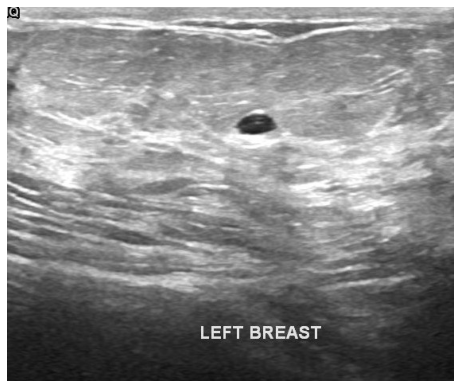

In [ ]:
img1 = open_image(img_files[0])
img1.show(figsize=(8,8))

## Y functions

In [10]:
def get_y_fn(x): return path/f"{x.parent.name}/{x.stem}{x.suffix}"
# def label_func(x): return path/f"{x.parent.name}/{x.stem}_mask{x.suffix}"
def label_func(x): 
  if 'mask_' not in x.stem:
    return path/f"{x.parent.name}/{x.stem}_mask{x.suffix}"

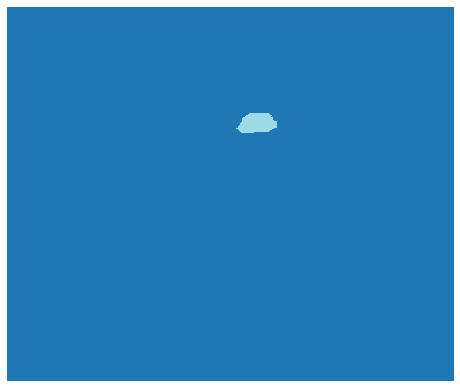

In [11]:
# img1_mask = open_image(lbl_names[2])
mask = open_mask(get_y_fn(mask_files[0]), div=True)
mask.show(figsize=(8,8), alpha=1)

In [12]:
# mask_tensor = np.array(mask)
mask.shape #, torch.unique(mask_tensor)

torch.Size([1, 471, 562])

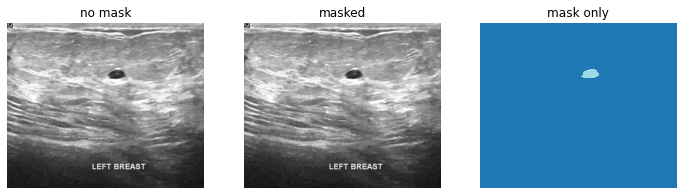

In [ ]:
_,axs = plt.subplots(1,3, figsize=(12,6))
img1.show(ax=axs[0], title='no mask')
img1.show(ax=axs[1], title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)


In [ ]:
rle_encode(mask.data)

'58472 62 59071 73 59673 79 60272 88 60870 99 61475 102 62077 110 62681 114 63283 122 63888 126 64493 129 65097 134 65703 138 66306 144 66912 147 67516 151 68121 156 68727 159 69333 162 69939 165 70546 167 71153 168 71760 170 72367 171 72974 173 73581 174 74188 176 74795 176 75402 176 76009 176 76616 177 77224 177 77831 176 78440 173 79047 172 79655 171 80264 168 80872 166 81479 165 82088 162 82699 157 83314 148 83927 141 84538 135 85152 127 85763 122 86371 119 86983 113 87594 105 88204 98 88815 85 89426 77 90038 63 90648 22'

In [13]:
src_size = np.array(mask.shape[1:])
src_size

array([471, 562])

In [14]:
size = src_size//2
size

array([235, 281])

In [15]:
codes = np.array(['benign', 'malignant', 'normal'])
codes

array(['benign', 'malignant', 'normal'], dtype='<U9')

## Mask converter

In [ ]:
from fastai.callbacks.hooks import *
import PIL.Image as PilImage

def get_class_values(label_names):
  contained_values = set([])
  # for i in range(len(label_names)):
  for i in label_names.iterdir():
    if not i.is_dir():
      tmp = open_mask(i.parent.name) #label_names[i])
      tmp = tmp.data.numpy().flatten()
      tmp = set(tmp)
      contained_values = contained_values.union(tmp)
  return list(contained_values)

def replace_mask_values_zero_to_n(mask, contained_values):
  number_of_classes = len(contained_values)
  new_mask = np.zeros(mask.shape)
  for i in range(len(number_of_classes)):
    new_mask[mask == contained_values[i]] = i
  return new_mask

def convert_mask_to_pil_and_save(mask, save_to):
  image_size = mask.squeeze().shape
  im = PilImage.new('L', (image_size[1], image_size[0]))
  im.putdata(mask.astype('uint8').ravel())
  im.save(save_to)

def convert_masks_to_grayscale_zero_to_n(label_names, save_to_path):
  # label_names = get_images_files(path_to_labels)
  contained_values = get_class_values(label_names)
  for current_file in label_names:
    current_mask = open_mask(current_file).data.numpy()
    converted_mask = replace_mask_values_zero_to_n(current_mask, contained_values)
    convert_mask_to_pil_and_save(converted_mask, save_to_path/f'{current_file.name}')
  print('Conversion finished!')

In [ ]:
class_values = get_class_values(mask_files[0]); class_values

NotADirectoryError: ignored

In [ ]:
# for m in mask_files[0].iterdir(): # .iterdir()
#   if not m.is_dir(): print(m)
# type(next(mask_files[0].iterdir()))
# range(len(mask_files))

In [ ]:
convert_masks_to_grayscale_zero_to_n(mask_files[:2], path)

TypeError: ignored

# Data loader

In [16]:
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

In [ ]:
src = (SegmentationItemList
        .from_folder(path)
        # .from_list(path, img_files, codes)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        # .label_from_folder()
        # .transform(get_transforms(do_flip=False), tfm_y=True, size=size) # size=128
        .transform(tfm_y=True, size=128) # size=128
        .databunch(bs=8, path=path)
        .normalize()
        # .normalize(imagenet_stats)
)

In [17]:
src = (SegmentationItemListWithDiv.from_folder(path, recurse=True)
        # .filter_by_func(lambda x: not x.name.endswith('_mask.png'))
        .filter_by_func(lambda x: '_mask' not in x.stem)
        .split_by_rand_pct()
      #  .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
        .label_from_func(label_func, classes=codes)) # get_y_fn

In [ ]:
test_l = src.label_from_func(get_y_fn, classes=codes); test_l

LabelLists;

Train: LabelList (624 items)
x: SegmentationItemListWithDiv
Image (3, 469, 555),Image (3, 574, 776),Image (3, 578, 770),Image (3, 494, 556),Image (3, 648, 757)
y: SegmentationLabelListWithDiv
ImageSegment (1, 469, 555),ImageSegment (1, 574, 776),ImageSegment (1, 578, 770),ImageSegment (1, 494, 556),ImageSegment (1, 648, 757)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Valid: LabelList (156 items)
x: SegmentationItemListWithDiv
Image (3, 331, 526),Image (3, 695, 810),Image (3, 582, 769),Image (3, 587, 620),Image (3, 461, 562)
y: SegmentationLabelListWithDiv
ImageSegment (1, 331, 526),ImageSegment (1, 695, 810),ImageSegment (1, 582, 769),ImageSegment (1, 587, 620),ImageSegment (1, 461, 562)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Test: None

In [18]:
dls = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=8)
        .normalize()
        # .normalize(imagenet_stats)
)

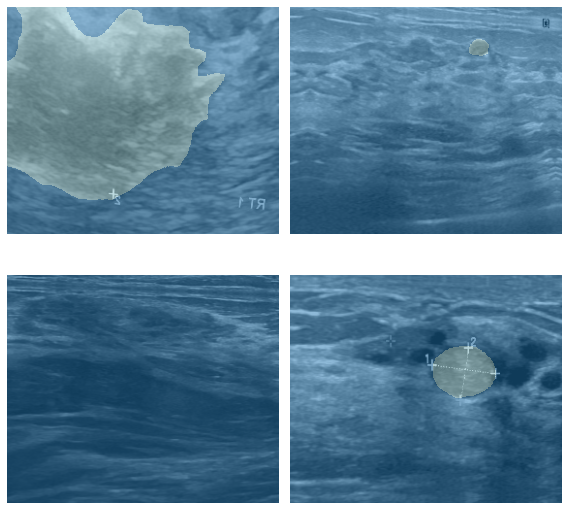

In [19]:
dls.show_batch(rows=2, figsize=(8,8), alpha=.5, reverse=True) # , class_names=codes

In [ ]:
dls.valid_ds.classes

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [ ]:
dls.single_from_classes

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
dls.train_ds[0]

(Image (3, 235, 281), ImageSegment (1, 235, 281))

In [ ]:
dls.valid_ds. # [0]

SegmentationLabelListWithDiv (156 items)
ImageSegment (1, 578, 772),ImageSegment (1, 451, 573),ImageSegment (1, 468, 552),ImageSegment (1, 464, 554),ImageSegment (1, 583, 779)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT

In [ ]:
dls.valid_ds

LabelList (156 items)
x: SegmentationItemListWithDiv
Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281)
y: SegmentationLabelListWithDiv
ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT

In [ ]:
dls.presize

<bound method _presize of ImageDataBunch;

Train: LabelList (624 items)
x: SegmentationItemListWithDiv
Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281)
y: SegmentationLabelListWithDiv
ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Valid: LabelList (156 items)
x: SegmentationItemListWithDiv
Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281)
y: SegmentationLabelListWithDiv
ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Test: None>

In [ ]:
dls.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (624 items)
x: SegmentationItemListWithDiv
Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281)
y: SegmentationLabelListWithDiv
ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Valid: LabelList (156 items)
x: SegmentationItemListWithDiv
Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281),Image (3, 235, 281)
y: SegmentationLabelListWithDiv
ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281),ImageSegment (1, 235, 281)
Path: /root/.fastai/data/breast-cancer/Dataset_BUSI_with_GT;

Test: None>

In [20]:
xc, yc = next(iter(dls.valid_dl))
torch.unique(yc)

tensor([0, 1], device='cuda:0')

# Model resnet34

In [44]:
def custom_loss(y_hat,y):
    y = y.squeeze(1)
    loss = nn.CrossEntropyLoss(ignore_index=255)
    return loss(y_hat,y)

In [21]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def segment_acc(input, target):
  target = target.squeeze(1)
  return (input.argmax(dim=1)==target).float().mean()

f_score = partial(fbeta, thresh=0.2)

In [22]:
# metrics=segment_acc
metrics=[segment_acc,f_score]

In [23]:
wd=1e-2

In [45]:
learn = unet_learner(dls, models.resnet34, #wd=wd, 
                    #  pretrained=False,
                    #  y_range=(0.1,0.9), 
                     loss_func=custom_loss,
                     metrics=metrics)

In [ ]:
learn.summary()
# learn.model

## Train stage 1

epoch,train_loss,valid_loss,segment_acc,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


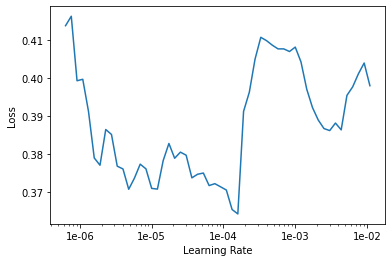

In [46]:
# 2021-04-22 pretrained. without y_range, wd. raw normalized.
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,segment_acc,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


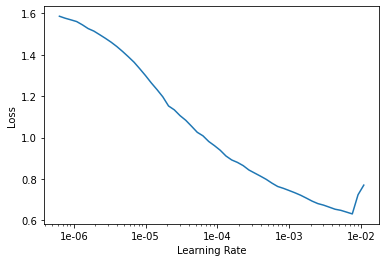

In [ ]:
# 2021-04-18 pretrained. without y_range, wd. raw normalized.
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,segment_acc,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


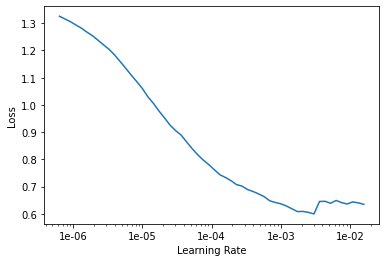

In [ ]:
# 2021-04-18 not pretrained. without y_range, wd. raw normalized.
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,segment_acc,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


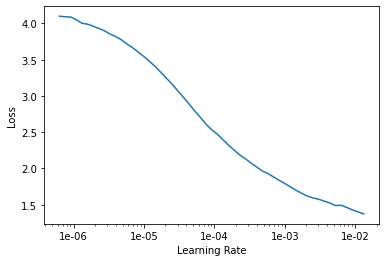

In [ ]:
# 2021-04-18  pretrained. without y_range, wd. imagenet normalized.
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,segment_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


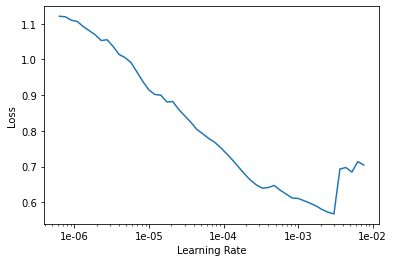

In [ ]:
# 2021-04-16 without y_range
lr_find(learn)
learn.recorder.plot()

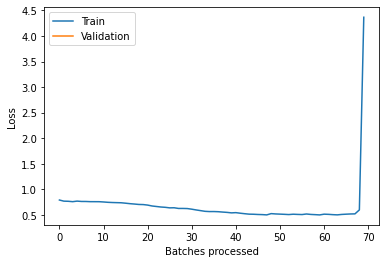

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save('rn34-stage-1');

In [ ]:
learn.load('rn34-stage-1')

In [26]:
lr = 1e-06

In [47]:
# 2021-04-22 pretrained. custom loss.
learn.fit_one_cycle(5, slice(1e-05), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.359204,0.278493,0.921646,0.129480,00:35
1,0.267873,0.202808,0.929139,0.130219,00:36
2,0.216311,0.183955,0.935531,0.129861,00:36
3,0.194030,0.167351,0.939963,0.128643,00:36
4,0.186549,0.165904,0.941331,0.129058,00:37


In [ ]:
# pretrained. raw normalized.
learn.fit_one_cycle(5, slice(1e-05), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.656557,0.372169,0.892197,0.155810,00:37
1,0.343509,0.250511,0.914935,0.153803,00:38
2,0.244867,0.214196,0.924404,0.153773,00:37
3,0.213989,0.201667,0.928442,0.153764,00:37
4,0.190264,0.200247,0.928293,0.153761,00:37


In [33]:
learn.fit_one_cycle(5, slice(lr), wd=wd, pct_start=0.9) # slice(1e-05,1e-02)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.735917,0.673783,0.734975,0.133201,00:39
1,0.595729,0.481899,0.861958,0.127657,00:39
2,0.489260,0.409297,0.893723,0.125267,00:39
3,0.412026,0.348372,0.909835,0.127663,00:39
4,0.368965,0.317430,0.915033,0.129029,00:39


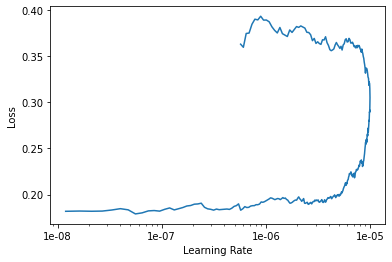

In [48]:
learn.recorder.plot()

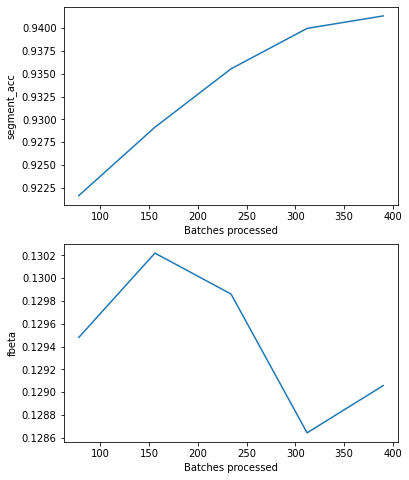

In [49]:
learn.recorder.plot_metrics()

In [51]:
learn.save('rn34-stage-2');

In [ ]:
learn.load('rn34-stage-2')

## Results stage 1

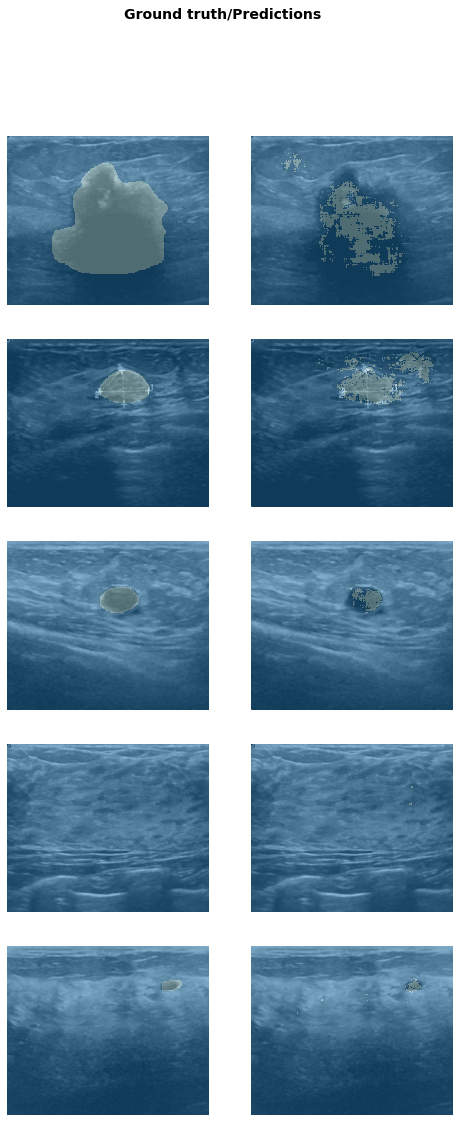

In [50]:
# learn.show_results(rows=3, cmap='Accent', figsize=(8, 9))
learn.show_results(figsize=(8,18))

## Unfreeze - stage 2

In [ ]:
# !!! cleanup GPU memory
learn=None
gc.collect()

In [59]:
learn.unfreeze()

In [60]:
# 2021-04-22pretrained. raw normalized.
learn.fit_one_cycle(10, slice(1e-05/3), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.187211,0.167434,0.940084,0.128711,00:37
1,0.182095,0.167559,0.940111,0.128058,00:38
2,0.171383,0.159754,0.941504,0.128354,00:38
3,0.171145,0.159533,0.943179,0.128559,00:39
4,0.174967,0.158836,0.941911,0.127844,00:39
5,0.173729,0.159272,0.943145,0.128232,00:39
6,0.165680,0.155207,0.943071,0.127356,00:39
7,0.167470,0.153215,0.943759,0.126038,00:39
8,0.161225,0.157839,0.942068,0.126967,00:39
9,0.161931,0.156855,0.941911,0.126416,00:39


In [ ]:
# pretrained. raw normalized.
learn.fit_one_cycle(20, slice(1e-06), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.182044,0.200920,0.928753,0.153761,00:37
1,0.185224,0.200621,0.929104,0.153760,00:37
2,0.191559,0.199428,0.929077,0.153757,00:37
3,0.190332,0.196951,0.929872,0.153756,00:37
4,0.184559,0.199506,0.928913,0.153752,00:37
5,0.180102,0.202181,0.929883,0.153748,00:37
6,0.185050,0.194288,0.930685,0.153746,00:37
7,0.177844,0.196282,0.930280,0.153745,00:37
8,0.174446,0.196607,0.929580,0.153742,00:37
9,0.176862,0.199069,0.929136,0.153741,00:37


In [ ]:
# pretrained. imagenet normalized.
learn.fit_one_cycle(10, slice(1e-06), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.193952,0.207608,0.922697,0.151760,01:36
1,0.191385,0.207901,0.925078,0.151756,01:36
2,0.191500,0.201987,0.925254,0.151754,01:35
3,0.184865,0.201407,0.926229,0.151753,01:36
4,0.195353,0.201731,0.923505,0.151752,01:36
5,0.199149,0.205014,0.922346,0.151750,01:36
6,0.190467,0.202436,0.925549,0.151750,01:36
7,0.196898,0.202678,0.925053,0.151749,01:36
8,0.187380,0.203164,0.923801,0.151749,01:35
9,0.190016,0.203009,0.925097,0.151748,01:36


In [62]:
learn.save('stage-3-unfreezed');

In [ ]:
learn.load('stage-3-unfreezed')

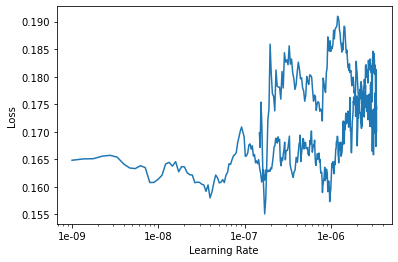

In [61]:
learn.recorder.plot()

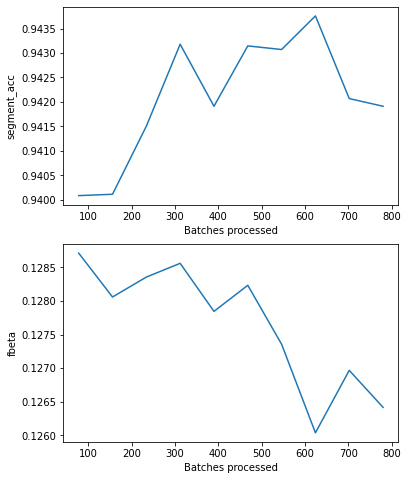

In [63]:
learn.recorder.plot_metrics()

## Results stage 2 unfreezed

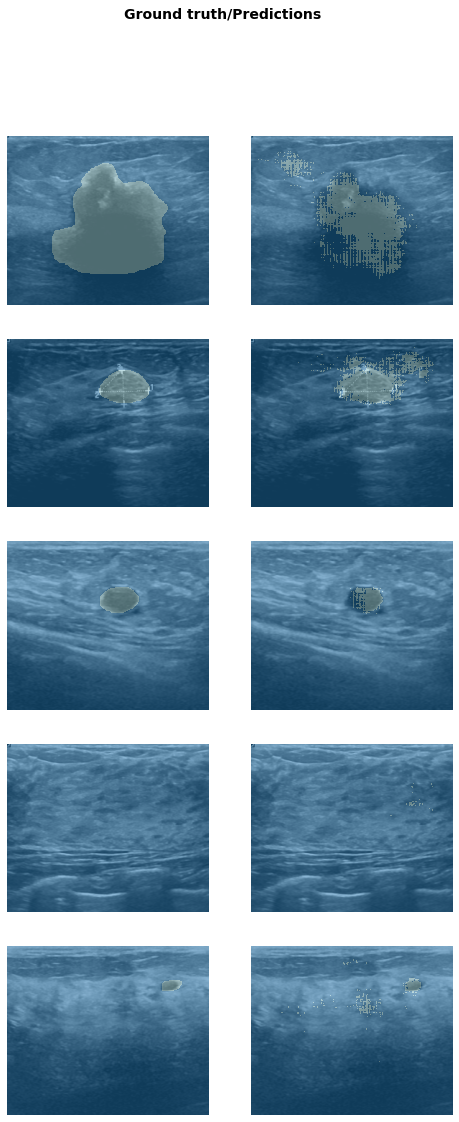

In [56]:
learn.show_results(figsize=(8,18))

## Learn some more stage 3

In [64]:
# pretrained. raw normalized.
learn.fit_one_cycle(20, slice(1e-8, 1e-06), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.165992,0.152149,0.944794,0.126710,00:38
1,0.162164,0.155095,0.944134,0.126946,00:38
2,0.167173,0.156907,0.942042,0.126072,00:39
3,0.167477,0.156592,0.942942,0.127145,00:39
4,0.171386,0.154553,0.943341,0.126995,00:39
5,0.167331,0.154013,0.943767,0.126451,00:39
6,0.171507,0.156180,0.942919,0.127220,00:39
7,0.164640,0.156133,0.943440,0.127151,00:39
8,0.166054,0.159301,0.942032,0.126925,00:39
9,0.168429,0.159018,0.942094,0.127428,00:39


In [69]:
learn.fit_one_cycle(10, slice(1e-06), wd=1e-2)

epoch,train_loss,valid_loss,segment_acc,fbeta,time
0,0.165897,0.153142,0.943851,0.127102,00:40
1,0.163150,0.155151,0.943844,0.127832,00:39
2,0.164320,0.155849,0.942374,0.126027,00:40
3,0.168619,0.155232,0.943317,0.127054,00:39
4,0.167418,0.153540,0.943880,0.126356,00:39
5,0.169356,0.161010,0.940193,0.126011,00:39
6,0.168102,0.156045,0.943291,0.126821,00:39
7,0.163114,0.157631,0.942739,0.126573,00:39
8,0.171954,0.156521,0.943398,0.126839,00:40
9,0.166601,0.160804,0.941204,0.126444,00:39


## Results stage 3

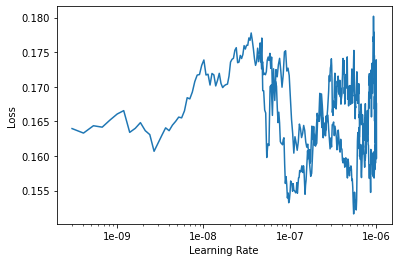

In [70]:
learn.recorder.plot()

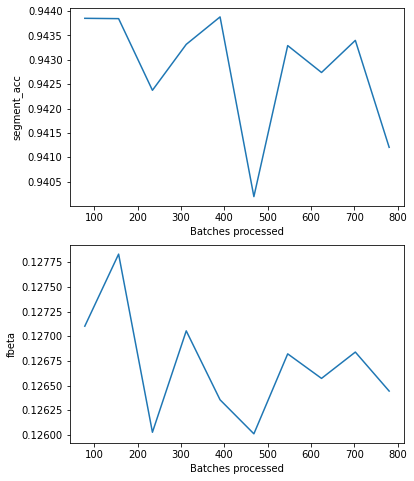

In [71]:
learn.recorder.plot_metrics()

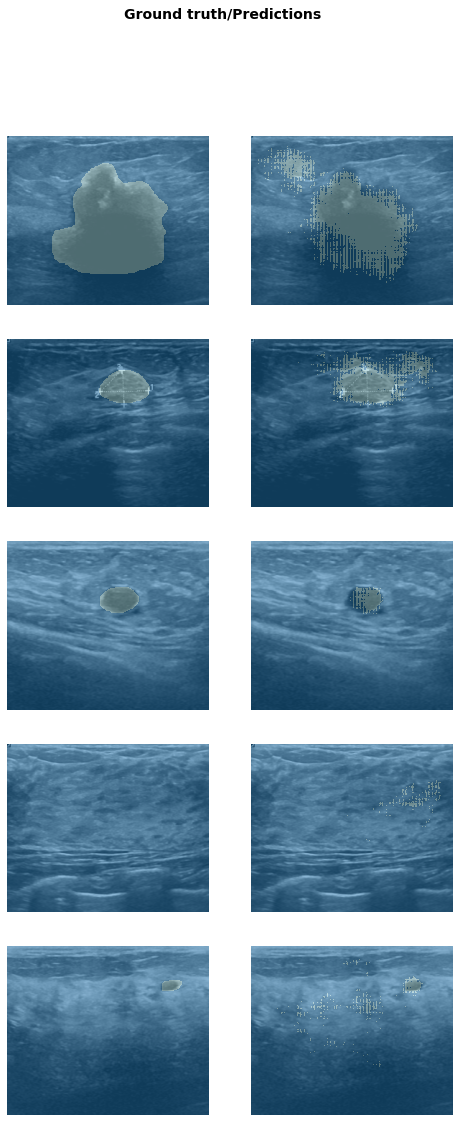

In [72]:
learn.show_results(figsize=(8,18))

# Model resnet34 hyper parameter search

# Model resnet50

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn = unet_learner(dls, models.resnet50, wd=wd, 
                     y_range=(0.0,1.0), 
                    #  loss_func=custom_loss,
                     metrics=metrics)

In [ ]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,segment_acc,time


RuntimeError: ignored